In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")


In [2]:
data_folder = r"D:\Pembangunan\Gabungan_label_numeric"
train_years = list(range(2014, 2023))
test_years = [2023, 2024]

print(train_years)

[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [3]:
feature_cols = ['UHH', 'HLS', 'RLS', 'PPP']
target_col = 'IPM'

In [4]:
def get_files(years, folder):
    files = []
    for y in years:
        path = os.path.join(folder, f"{y}_numeric.csv")
        if os.path.exists(path):
            files.append(path)
        else:
            print(f"Warning: File {y}_numeric.csv tidak ditemukan!")
    return sorted(files)

In [5]:
train_files = get_files(train_years, data_folder)
test_files  = get_files(test_years, data_folder)

df_train = pd.concat([pd.read_csv(f, encoding='utf-8') for f in train_files], ignore_index=True)
df_test  = pd.concat([pd.read_csv(f, encoding='utf-8') for f in test_files], ignore_index=True)


In [6]:
X_train = df_train[feature_cols]
y_train = df_train[target_col]

X_test = df_test[feature_cols]
y_test = df_test[target_col]

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [8]:
print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("y_train distribusi:\n", y_train.value_counts())
print("y_test distribusi:\n", y_test.value_counts())

X_train shape: (5211, 4)
X_test shape: (1158, 4)
y_train distribusi:
 IPM
2    2764
3    1895
1     301
4     251
Name: count, dtype: int64
y_test distribusi:
 IPM
3    610
2    380
4    112
1     56
Name: count, dtype: int64


In [9]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', decision_function_shape='ovr', random_state=42, probability=True), # probability=True agar bisa log_loss
    "MLP (ANN)": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42),
    "Logistic Regression": LogisticRegression(multi_class='multinomial', max_iter=500, solver='lbfgs', random_state=42)
}

In [10]:
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    try:
        y_proba = model.predict_proba(X_test_scaled)
        ll = log_loss(y_test, y_proba)
    except AttributeError:
        ll = None
        print(f"Warning: {name} tidak mendukung predict_proba, log_loss tidak dihitung.")
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Accuracy: {acc:.4f}, Weighted F1-score: {f1:.4f}, Log-loss: {ll}")
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))
    
    results.append({"Model": name, "Accuracy": acc, "Weighted F1": f1, "Log-loss": ll})



Training Decision Tree...
Accuracy: 0.8946, Weighted F1-score: 0.8944, Log-loss: 3.797345175710097
Classification Report:
               precision    recall  f1-score   support

           1      0.843     0.768     0.804        56
           2      0.897     0.897     0.897       380
           3      0.900     0.913     0.906       610
           4      0.880     0.848     0.864       112

    accuracy                          0.895      1158
   macro avg      0.880     0.857     0.868      1158
weighted avg      0.894     0.895     0.894      1158


Training Random Forest...
Accuracy: 0.9283, Weighted F1-score: 0.9274, Log-loss: 0.24468824367960176
Classification Report:
               precision    recall  f1-score   support

           1      1.000     0.679     0.809        56
           2      0.907     0.955     0.931       380
           3      0.935     0.936     0.935       610
           4      0.945     0.920     0.932       112

    accuracy                          0.928

In [11]:
results_df = pd.DataFrame(results)
print("\n=== Ringkasan Performa Semua Model ===")
print(results_df)


=== Ringkasan Performa Semua Model ===
                 Model  Accuracy  Weighted F1  Log-loss
0        Decision Tree  0.894646     0.894350  3.797345
1        Random Forest  0.928325     0.927374  0.244688
2    Gradient Boosting  0.938687     0.937415  0.226510
3             AdaBoost  0.823834     0.805929  1.338794
4                  SVM  0.966321     0.965048  0.198663
5            MLP (ANN)  0.970639     0.969554  0.106151
6  Logistic Regression  0.954231     0.952238  0.530161



=== Confusion Matrix: Decision Tree ===
[[ 43   3  10   0]
 [  2 341  35   2]
 [  6  36 557  11]
 [  0   0  17  95]]


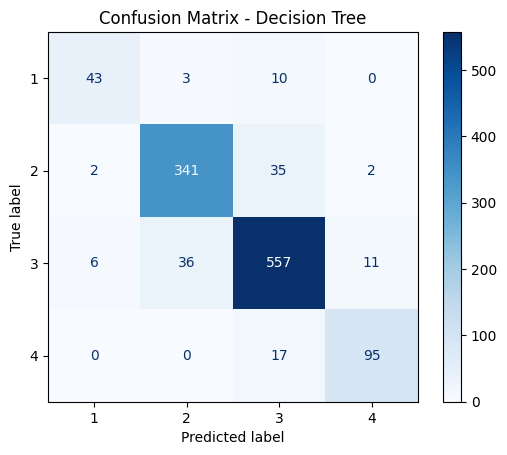


=== Confusion Matrix: Random Forest ===
[[ 38   2  16   0]
 [  0 363  15   2]
 [  0  35 571   4]
 [  0   0   9 103]]


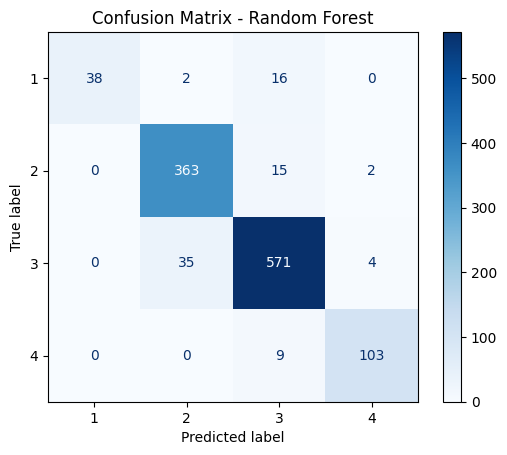


=== Confusion Matrix: Gradient Boosting ===
[[ 37   3  16   0]
 [  0 367  11   2]
 [  2  24 581   3]
 [  0   0  10 102]]


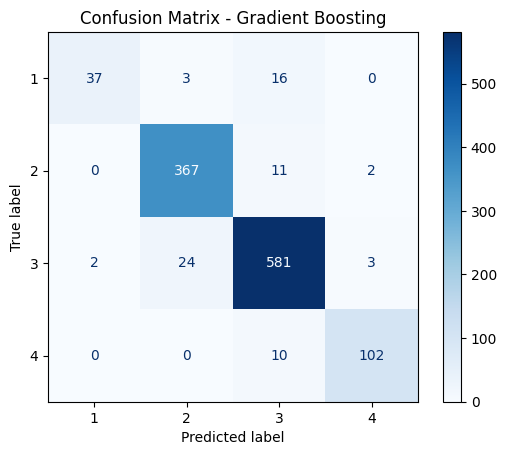


=== Confusion Matrix: AdaBoost ===
[[  0  40  16   0]
 [  0 342  37   1]
 [  0  97 509   4]
 [  0   0   9 103]]


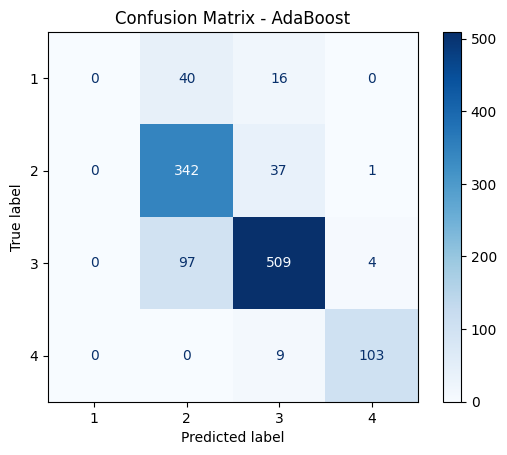


=== Confusion Matrix: SVM ===
[[ 38   2  16   0]
 [  0 371   7   2]
 [  0   4 604   2]
 [  0   0   6 106]]


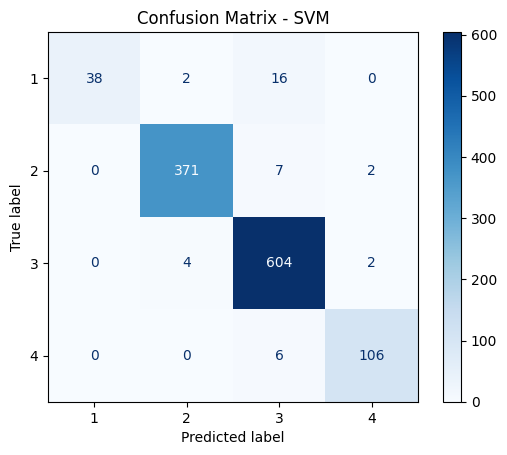


=== Confusion Matrix: MLP (ANN) ===
[[ 39   1  16   0]
 [  0 371   6   3]
 [  0   3 602   5]
 [  0   0   0 112]]


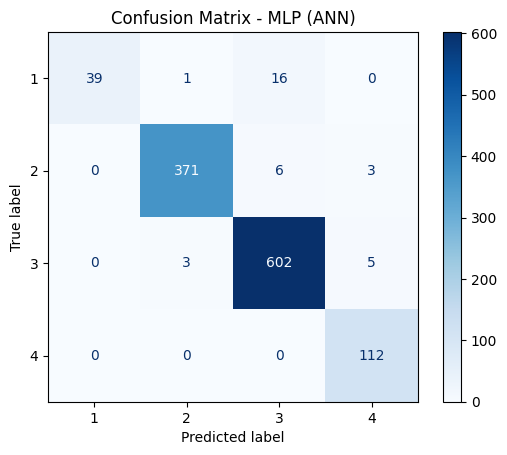


=== Confusion Matrix: Logistic Regression ===
[[ 34   6  16   0]
 [  0 370   8   2]
 [  0  12 596   2]
 [  0   0   7 105]]


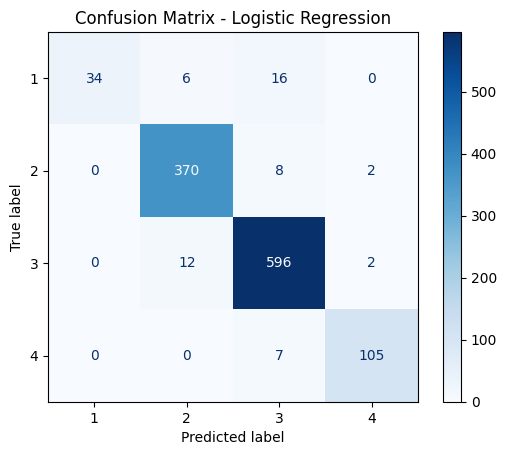

In [12]:
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4])
    
    print(f"\n=== Confusion Matrix: {name} ===")
    print(cm)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [13]:
summary_results = []

classes = [1,2,3,4]

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    
    # Hitung total benar dan salah
    total_correct = np.sum(y_pred == y_test)
    total_incorrect = np.sum(y_pred != y_test)
    
    # Hitung per kelas
    correct_per_class = []
    incorrect_per_class = []
    for c in classes:
        correct_c = np.sum((y_test==c) & (y_pred==c))
        incorrect_c = np.sum((y_test==c) & (y_pred!=c))
        correct_per_class.append(correct_c)
        incorrect_per_class.append(incorrect_c)
    
    summary_results.append({
        "Model": name,
        "Total Benar": total_correct,
        "Total Salah": total_incorrect,
        "Persentase Benar": round(total_correct / (total_correct + total_incorrect) * 100,2),
        "Persentase Salah": round(total_incorrect / (total_correct + total_incorrect) * 100,2),
        "Benar per Kelas": correct_per_class,
        "Salah per Kelas": incorrect_per_class
    })

summary_df = pd.DataFrame(summary_results)
pd.set_option('display.max_columns', None)
print(summary_df)

                 Model  Total Benar  Total Salah  Persentase Benar  \
0        Decision Tree         1036          122             89.46   
1        Random Forest         1075           83             92.83   
2    Gradient Boosting         1087           71             93.87   
3             AdaBoost          954          204             82.38   
4                  SVM         1119           39             96.63   
5            MLP (ANN)         1124           34             97.06   
6  Logistic Regression         1105           53             95.42   

   Persentase Salah      Benar per Kelas   Salah per Kelas  
0             10.54   [43, 341, 557, 95]  [13, 39, 53, 17]  
1              7.17  [38, 363, 571, 103]   [18, 17, 39, 9]  
2              6.13  [37, 367, 581, 102]  [19, 13, 29, 10]  
3             17.62   [0, 342, 509, 103]  [56, 38, 101, 9]  
4              3.37  [38, 371, 604, 106]     [18, 9, 6, 6]  
5              2.94  [39, 371, 602, 112]     [17, 9, 8, 0]  
6           

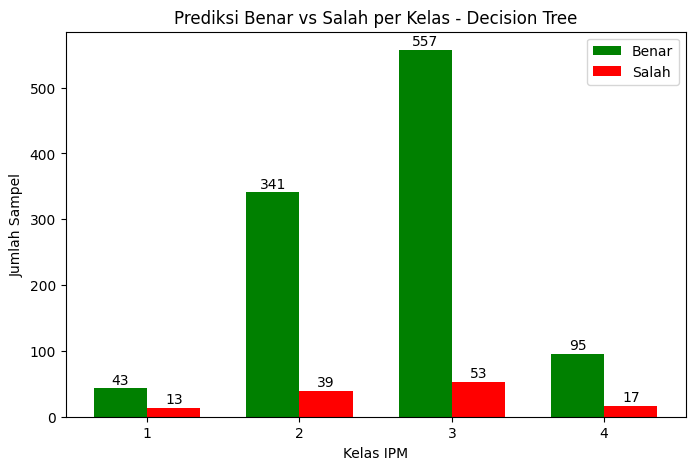

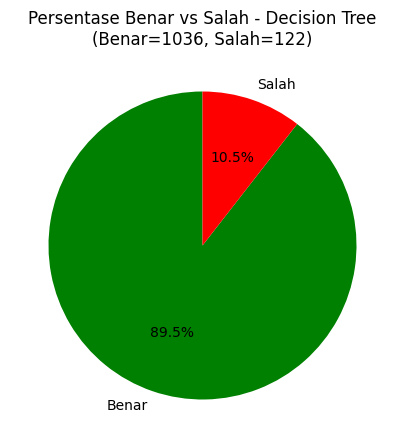

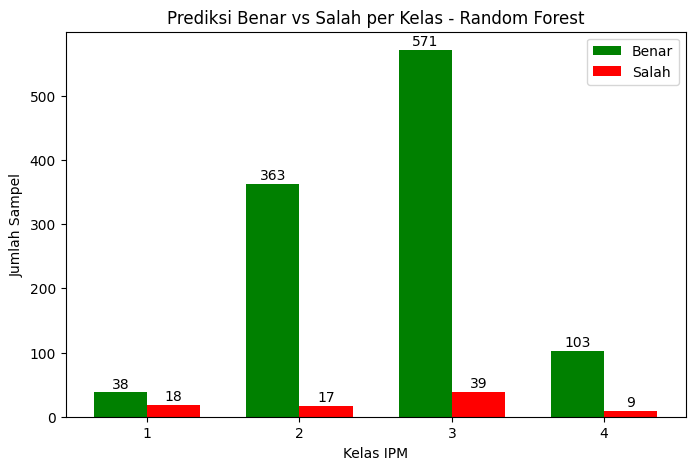

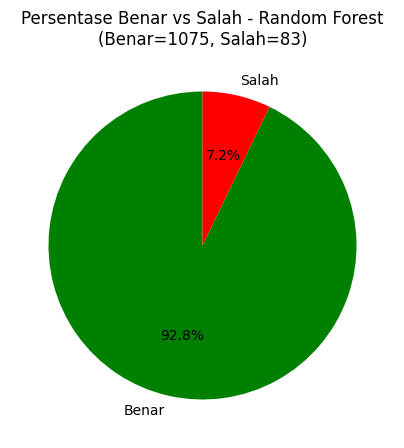

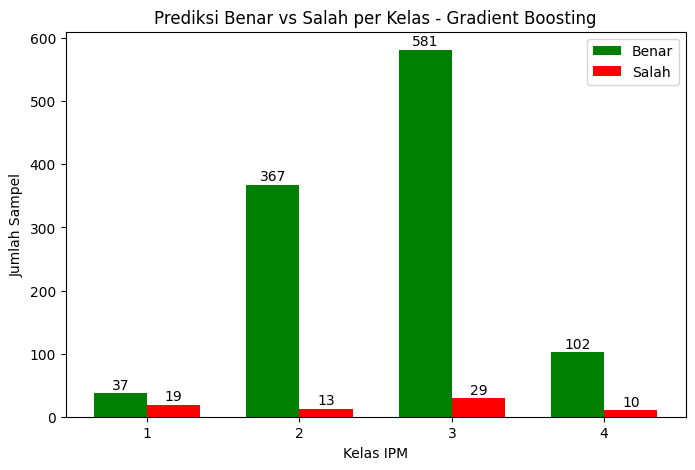

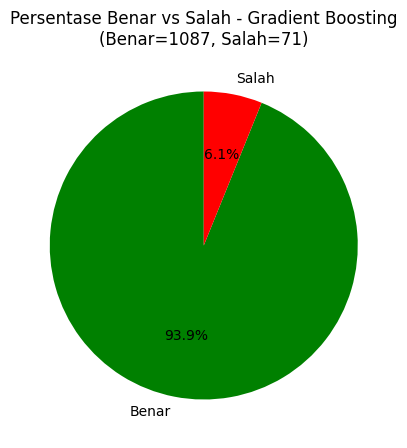

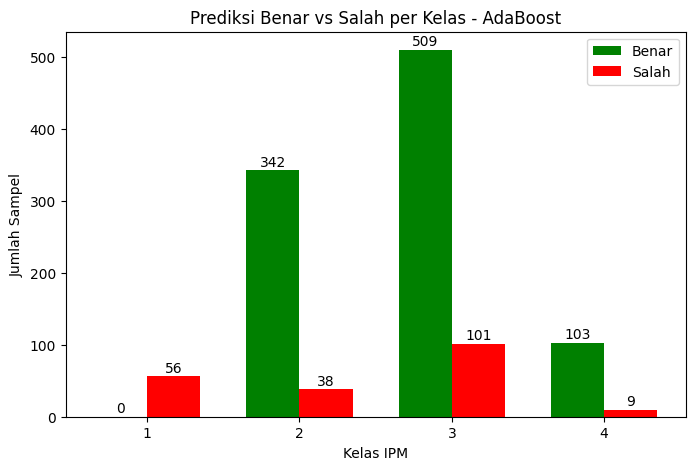

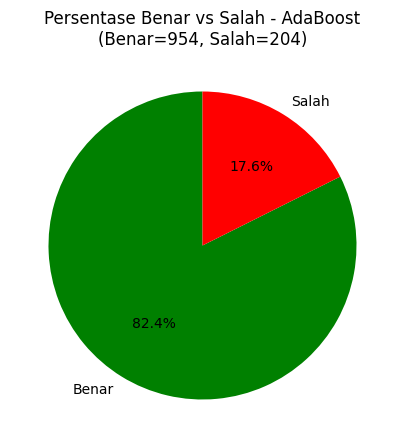

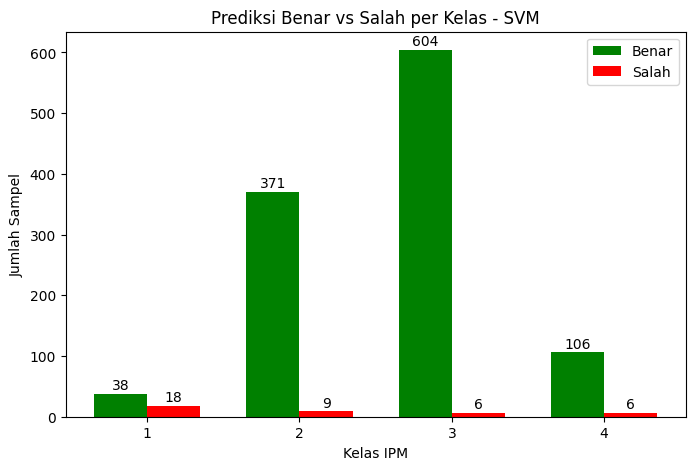

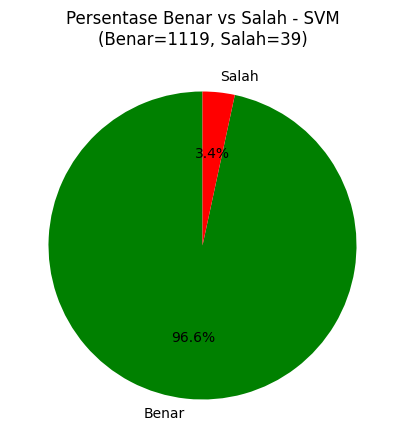

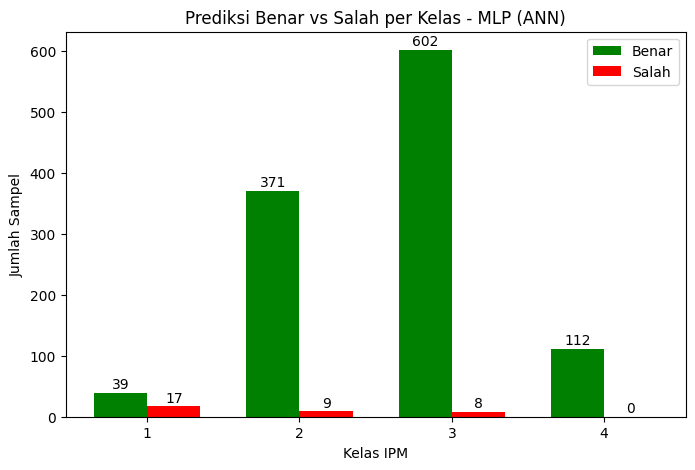

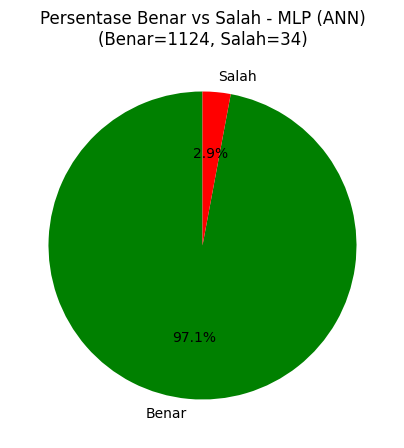

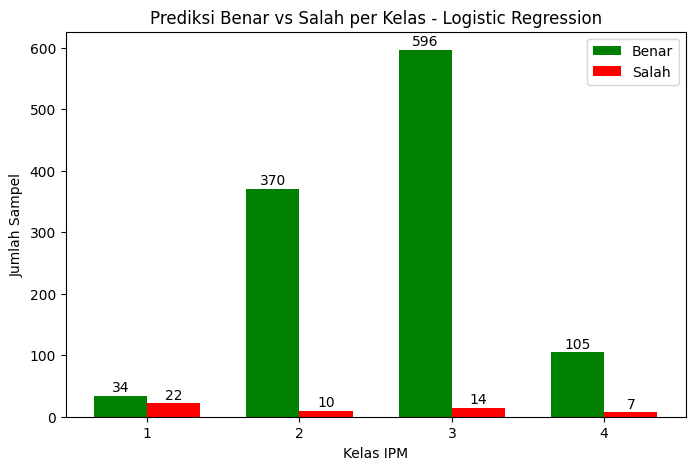

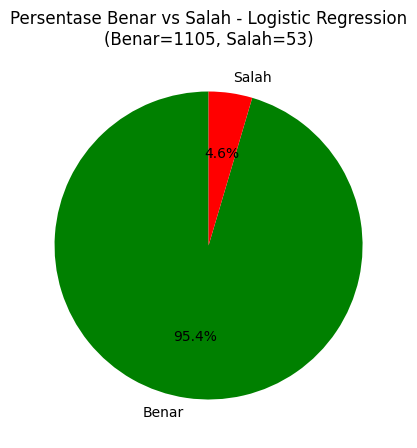

In [14]:
classes = [1,2,3,4]

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    
    correct_per_class = []
    incorrect_per_class = []
    for c in classes:
        correct = np.sum((y_test==c) & (y_pred==c))
        incorrect = np.sum((y_test==c) & (y_pred!=c))
        correct_per_class.append(correct)
        incorrect_per_class.append(incorrect)

    x = np.arange(len(classes))
    width = 0.35
    
    # Bar chart
    plt.figure(figsize=(8,5))
    bars_correct = plt.bar(x - width/2, correct_per_class, width, label='Benar', color='green')
    bars_incorrect = plt.bar(x + width/2, incorrect_per_class, width, label='Salah', color='red')
    
    for bar in bars_correct:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, str(bar.get_height()), ha='center', va='bottom', fontsize=10)
    for bar in bars_incorrect:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, str(bar.get_height()), ha='center', va='bottom', fontsize=10)
    
    plt.xticks(x, classes)
    plt.xlabel("Kelas IPM")
    plt.ylabel("Jumlah Sampel")
    plt.title(f"Prediksi Benar vs Salah per Kelas - {name}")
    plt.legend()
    plt.show()
    
    # Pie chart
    total_correct = sum(correct_per_class)
    total_incorrect = sum(incorrect_per_class)
    
    plt.figure(figsize=(5,5))
    plt.pie([total_correct, total_incorrect], labels=['Benar','Salah'],
            autopct='%1.1f%%', colors=['green','red'], startangle=90)
    plt.title(f"Persentase Benar vs Salah - {name}\n(Benar={total_correct}, Salah={total_incorrect})")
    plt.show()
